<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_naranja@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio NLP + Sist. Recomendación


En este laboratorio, tabrajaras con datos de reseñas de productos para construir un sistema de recomendación que utilice procesamiento de lenguaje natural (NLP) y *machine learning*. El objetivo principal es que analices el contenido textual de las reseñas, clasifiques las opiniones en categorías (positiva, negativa o neutra) y aproveches esta información para personalizar las recomendaciones. El sistema priorizará los productos con mejores reseñas para usuarios específicos y permitirá evaluar si el análisis de sentimientos mejora la calidad de las recomendaciones. Tareas propuestas:


**Caso 1: Crear un sistema de recomendación**: Debes generar un sistema de recomendación para priorizar productos con las reseñas para cada usuario. Los pasos que deberás seguir son:    

- Estructurar el conjunto de datos

- Sistema basado en contenido


**Caso 2: Clasificar reseñas en positivas, negativas o neutras** Deberás implementar un modelo para analizar las reseñas textuales y clasificarlas en tres categorías:

- Positivas: Si el sentimiento de la reseña es favorable.

- Negativas: Si el sentimiento de la reseña es desfavorable.

- Neutras: Si la reseña no tiene un sentimiento claro.
	
- Pasos :
	- Preprocesamiento de texto: Limpiar las reseñas eliminando caracteres especiales, palabras vacías (stopwords) y realizar lematización.
	
	- Identificar las reseñas positivas, negativas y neutrales. 


Los datos los tendréis en el [siguiente enlace](https://drive.google.com/drive/u/0/folders/1vK5zESy9KElRhm_utg_lHHXuUArrwWgu) con la descipción de cada una de las columnas.  

In [1]:
import pandas as pd 
import numpy as np 
import pickle 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import pdist, squareform    #Para calcular distancias en varios plano (pdist), para medir distancia aplanando todo (squareform)
import warnings

warnings.filterwarnings("ignore")

import sys
import os
sys.path.append(os.path.abspath("src"))   
import soporte_sistemas_recomendacion_nlp as f




# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import math
import re
from wordcloud import WordCloud

# Para modelos NLP
# -----------------------------------------------------------------------
import spacy
from nltk.corpus import stopwords
import nltk
import contractions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.metrics import accuracy_score, classification_report
import string


from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix


# Configuración de pandas
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None)


# Otros
# -----------------------------------------------------------------------
from collections import Counter

In [2]:
datos=pd.read_csv("datos/datos.csv", index_col=0)

In [3]:
datos.shape

(10000, 9)

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 65115 to 43619
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewId            10000 non-null  object 
 1   reviewDate          10000 non-null  object 
 2   mainDepartment      10000 non-null  object 
 3   subDepartment       10000 non-null  object 
 4   productName         10000 non-null  object 
 5   reviewTitle         9995 non-null   object 
 6   reviewStar          10000 non-null  float64
 7   reviewText          9999 non-null   object 
 8   inconsistentStatus  10000 non-null  int64  
dtypes: float64(1), int64(1), object(7)
memory usage: 781.2+ KB


Hay 2 columnas con nulos que eliminamos que son 6

In [5]:
datos.dropna(inplace=True)

In [6]:
datos.isna().sum()

reviewId              0
reviewDate            0
mainDepartment        0
subDepartment         0
productName           0
reviewTitle           0
reviewStar            0
reviewText            0
inconsistentStatus    0
dtype: int64

In [7]:
datos.reset_index(drop=True, inplace=True)

In [8]:
datos.duplicated().sum()

0

In [9]:
datos.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,Doctor Developed Copper Wrist Brace / Carpal T...,One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,Fruit of the Loom Men's Coolzone Boxer Briefs,They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"TP-Link AC750 WiFi Extender (RE220), Covers Up...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"Gorilla Grip Luxury Chenille Bathroom Rug Mat,...",Color wrong!!!,1.0,The color is completely different than hunter ...,1
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,WOW Apple Cider Vinegar Shampoo and Hair Condi...,I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0


### **Por lo que noto hay que tratar la columna reviewerName**

In [10]:
datos["reviewText"]

0       Nice lightweight brace but unfortunately was t...
1       Boxers were ok. The color did start to fade pr...
2       Very easy to install. Worked right away but it...
3       The color is completely different than hunter ...
4       From reading the reviews, I was hoping that th...
                              ...                        
9990    This scale is great for food prep. It is fast ...
9991    Comfortable but a little small.  Rides down on...
9992    Really great volleyball for the water!! Only p...
9993                   Good fit and  comfortable to wear.
9994    These are great pillows, just not for me. They...
Name: reviewText, Length: 9995, dtype: object

In [11]:
nltk.download("stopwords")
nlp=spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaime\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [12]:


def formatear_texto(text):
    if not isinstance(text, str):  # no aseguramos que sea un texto
        raise ValueError("La entrada debe ser una cadena de texto.")
    text = text.lower()
    text = contractions.fix(text)                      #Quita las contracciones
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    

    doc=nlp(text)

    
    stop_words = set(stopwords.words("english"))
    

    palabras_def=[]
    for palabra in doc:
        if palabra not in stop_words:
            palabras_def.append(palabra) 

    
    return palabras_def



In [13]:
datos["productName"]=datos["productName"].apply(formatear_texto)

In [14]:
datos["producto_fuera_lista"] = datos["productName"].apply(lambda x: ' '.join(str(token) for token in x))

In [15]:
datos["producto_fuera_lista"].dtype

dtype('O')

In [16]:
datos.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,producto_fuera_lista
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,"[doctor, developed, copper, wrist, brace, carp...",One size does not fit all.,3.0,Nice lightweight brace but unfortunately was t...,1,doctor developed copper wrist brace carpal tun...
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,"[fruit, of, the, loom, men, s, coolzone, boxer...",They were ok but thats it,4.0,Boxers were ok. The color did start to fade pr...,0,fruit of the loom men s coolzone boxer briefs
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"[tp, link, ac750, wifi, extender, re220, cover...",Good if you need a little extra.,4.0,Very easy to install. Worked right away but it...,0,tp link ac750 wifi extender re220 covers up to...
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"[gorilla, grip, luxury, chenille, bathroom, ru...",Color wrong!!!,1.0,The color is completely different than hunter ...,1,gorilla grip luxury chenille bathroom rug mat ...
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,"[wow, apple, cider, vinegar, shampoo, and, hai...",I have 4A hair,2.0,"From reading the reviews, I was hoping that th...",0,wow apple cider vinegar shampoo and hair condi...


In [17]:
datos["producto_fuera_lista"]

0       doctor developed copper wrist brace carpal tun...
1           fruit of the loom men s coolzone boxer briefs
2       tp link ac750 wifi extender re220 covers up to...
3       gorilla grip luxury chenille bathroom rug mat ...
4       wow apple cider vinegar shampoo and hair condi...
                              ...                        
9990    etekcity food kitchen scale digital grams and ...
9991    saucony men s multi pack mesh ventilating comf...
9992                          wilson soft play volleyball
9993        fruit of the loom men s coolzone boxer briefs
9994    beckham hotel collection bed pillows for sleep...
Name: producto_fuera_lista, Length: 9995, dtype: object

In [18]:
datos["producto_fuera_lista"][0]

'doctor developed copper wrist brace carpal tunnel wrist brace wrist support wrist splint hand brace f d a class i medical device doctor handbook night support for women men right left hands single'

## Comenzamos con el sistema de recomendación de contenido

In [19]:
datos["reviewText"] 

0       Nice lightweight brace but unfortunately was t...
1       Boxers were ok. The color did start to fade pr...
2       Very easy to install. Worked right away but it...
3       The color is completely different than hunter ...
4       From reading the reviews, I was hoping that th...
                              ...                        
9990    This scale is great for food prep. It is fast ...
9991    Comfortable but a little small.  Rides down on...
9992    Really great volleyball for the water!! Only p...
9993                   Good fit and  comfortable to wear.
9994    These are great pillows, just not for me. They...
Name: reviewText, Length: 9995, dtype: object

## Ahora ya especificamos el sistema de recomendación

In [20]:
vectorizer=CountVectorizer(stop_words="english")
vectorizer

CountVectorizer(stop_words='english')

Ahora ya tenemos todas nuestras palabras tagueadas

In [21]:
X=vectorizer.fit_transform(datos["reviewText"]).toarray()
X[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [22]:
similarity=cosine_similarity(X)


In [23]:
user_like_product="doctor developed copper wrist brace carpal tunnel wrist brace wrist support wrist splint hand brace f d a class i medical device doctor handbook night support for women men right left hands single"
product_index= f.get_index_from_name(user_like_product,"producto_fuera_lista", datos)   #esto me devuelve el indice del producto
product_index

0

aqui sacamos los indices y distancias del resto de los productos respecto a nuestro producto

In [24]:
similar_products=list(enumerate(similarity[product_index]))
similar_products[1:5]

[(1, 0.0700140042014005), (2, 0.0), (3, 0.0), (4, 0.0)]

Lo ordenamos para que nos de los productos que más se parecen a nuestro producto

In [25]:
sorted_products=sorted(similar_products, key=lambda x: x[1], reverse=True)
sorted_products[1:5]

[(9231, 0.48507125007266594),
 (4699, 0.4551495636817563),
 (1673, 0.45257527085942606),
 (6488, 0.4338609156373123)]

In [26]:
top_product ={}
for i in sorted_products[1:21]:
    top_product[f.get_name_from_index(i[0], datos, "producto_fuera_lista")]=i[1]

l_tup_ordenado=sorted(top_product.items(), key = lambda x : x[1], reverse=True)
diccionario_ordenado = {clave: valor for clave, valor in l_tup_ordenado}


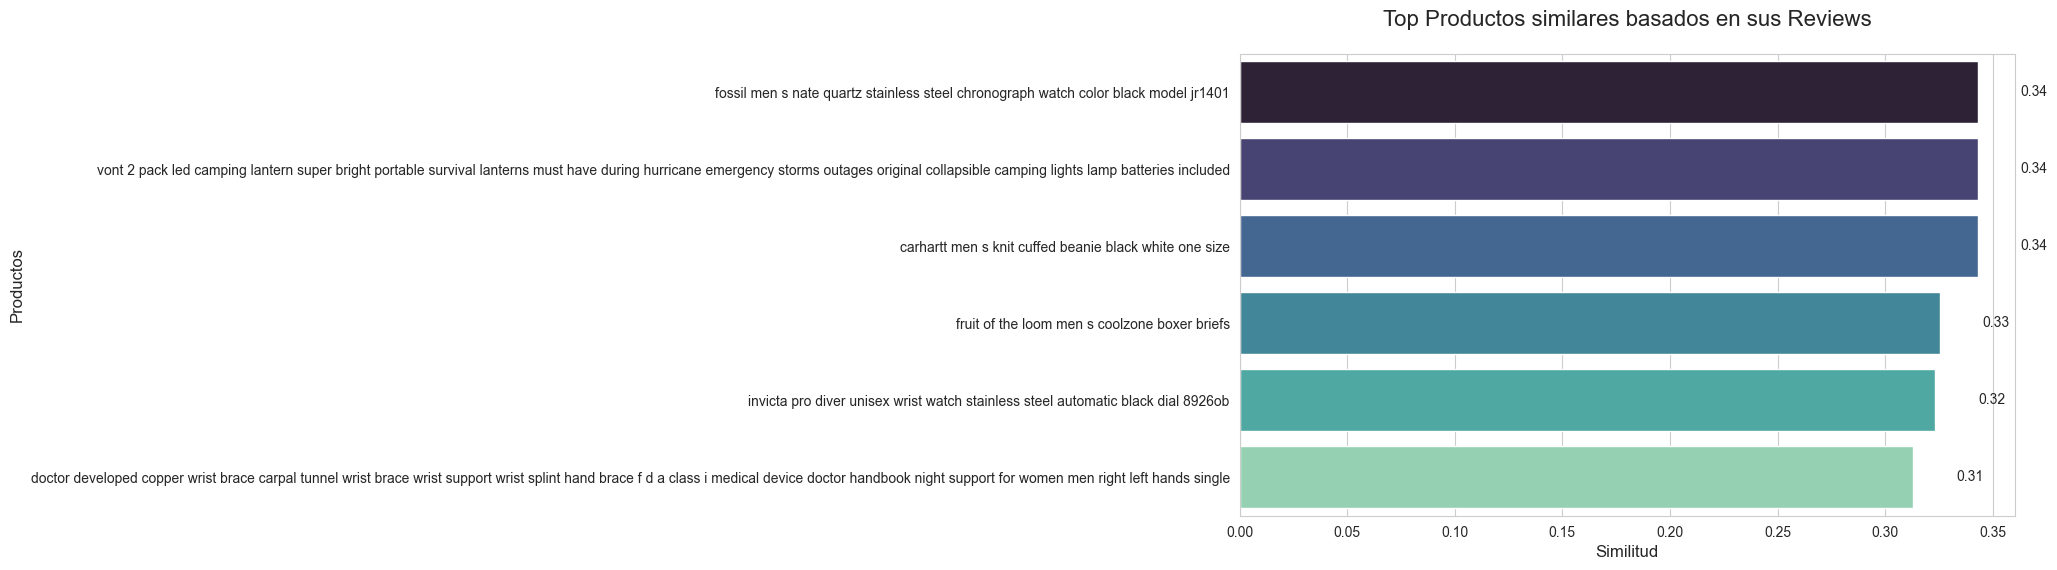

In [27]:
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.barplot(
    x=list(diccionario_ordenado.values()), 
    y=list(diccionario_ordenado.keys()), 
    palette="mako"
)

plt.title("Top Productos similares basados en sus Reviews", fontsize=16, pad=20)
plt.xlabel("Similitud", fontsize=12)
plt.ylabel("Productos", fontsize=12)

# Añadir valores al final de cada barra
for i, value in enumerate(diccionario_ordenado.values()):
    plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

plt.tight_layout();

### AHORA PONGO A PRUEBA MI SISTEMA DE RECOMENDACIÓN CON 5 PRODUCTOS AL AZAR

In [28]:
conjunto_prueba=list(datos["producto_fuera_lista"].sample(5, random_state=42))

In [29]:
conjunto_prueba

['nautica voyage by nautica for men eau de toilette spray 100 ml',
 'ailun glass screen protector compatible for iphone 11 iphone xr 6 1 inch 3 pack tempered glass',
 'mosiso laptop sleeve bag compatible with 13 13 3 inch macbook pro macbook air notebook computer polyester vertical case with pocket gray',
 'wow apple cider vinegar shampoo and hair conditioner set increase gloss hydration shine reduce itchy scalp dandruff frizz no parabens or sulfates all hair types 2 x 16 9 fl oz 500ml',
 'revlon one step hair dryer and volumizer hot air brush black packaging may vary']

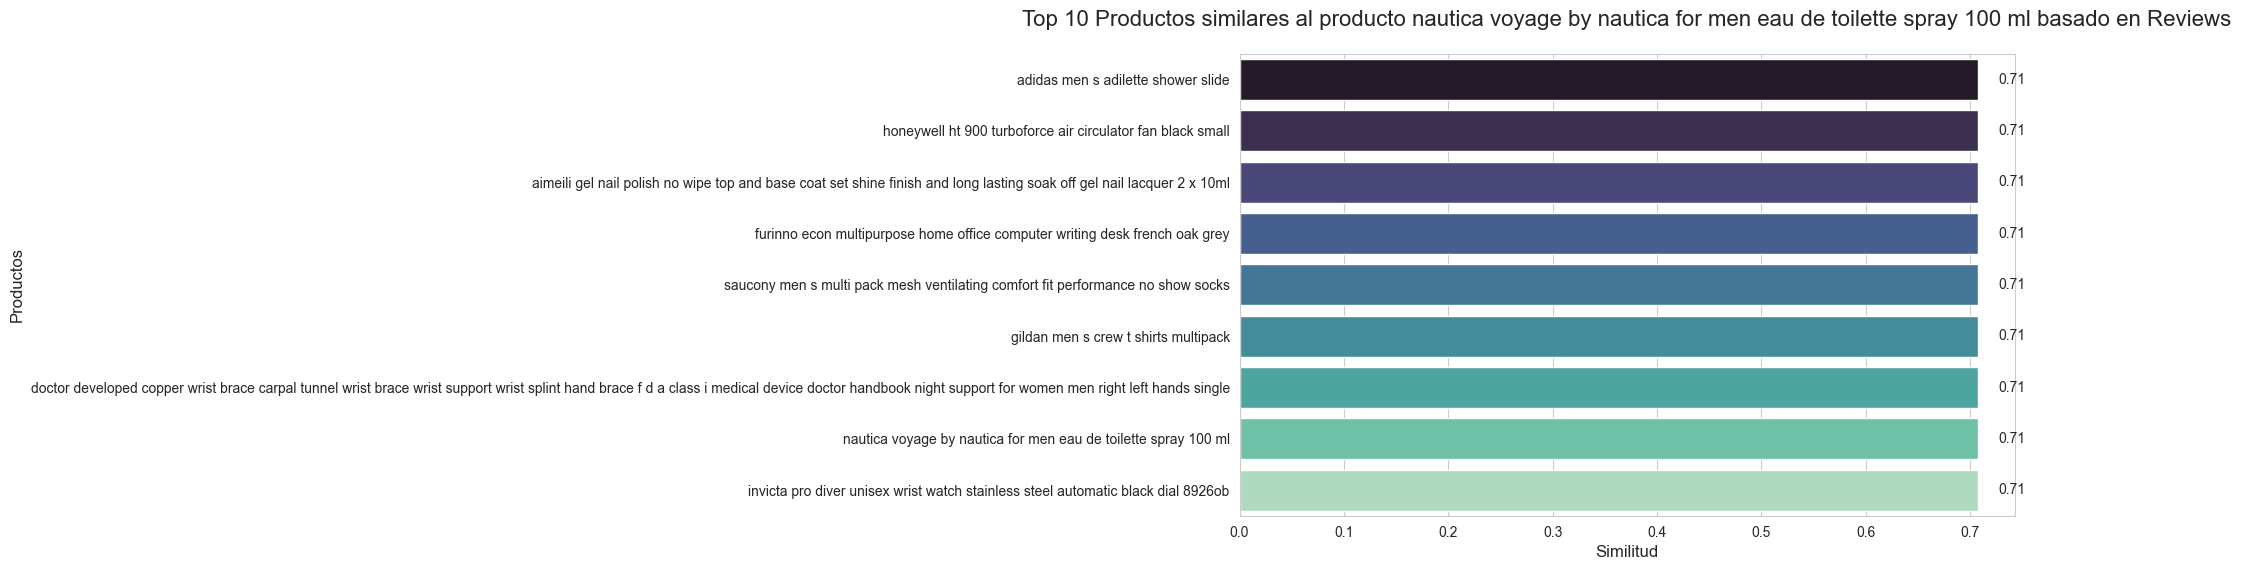

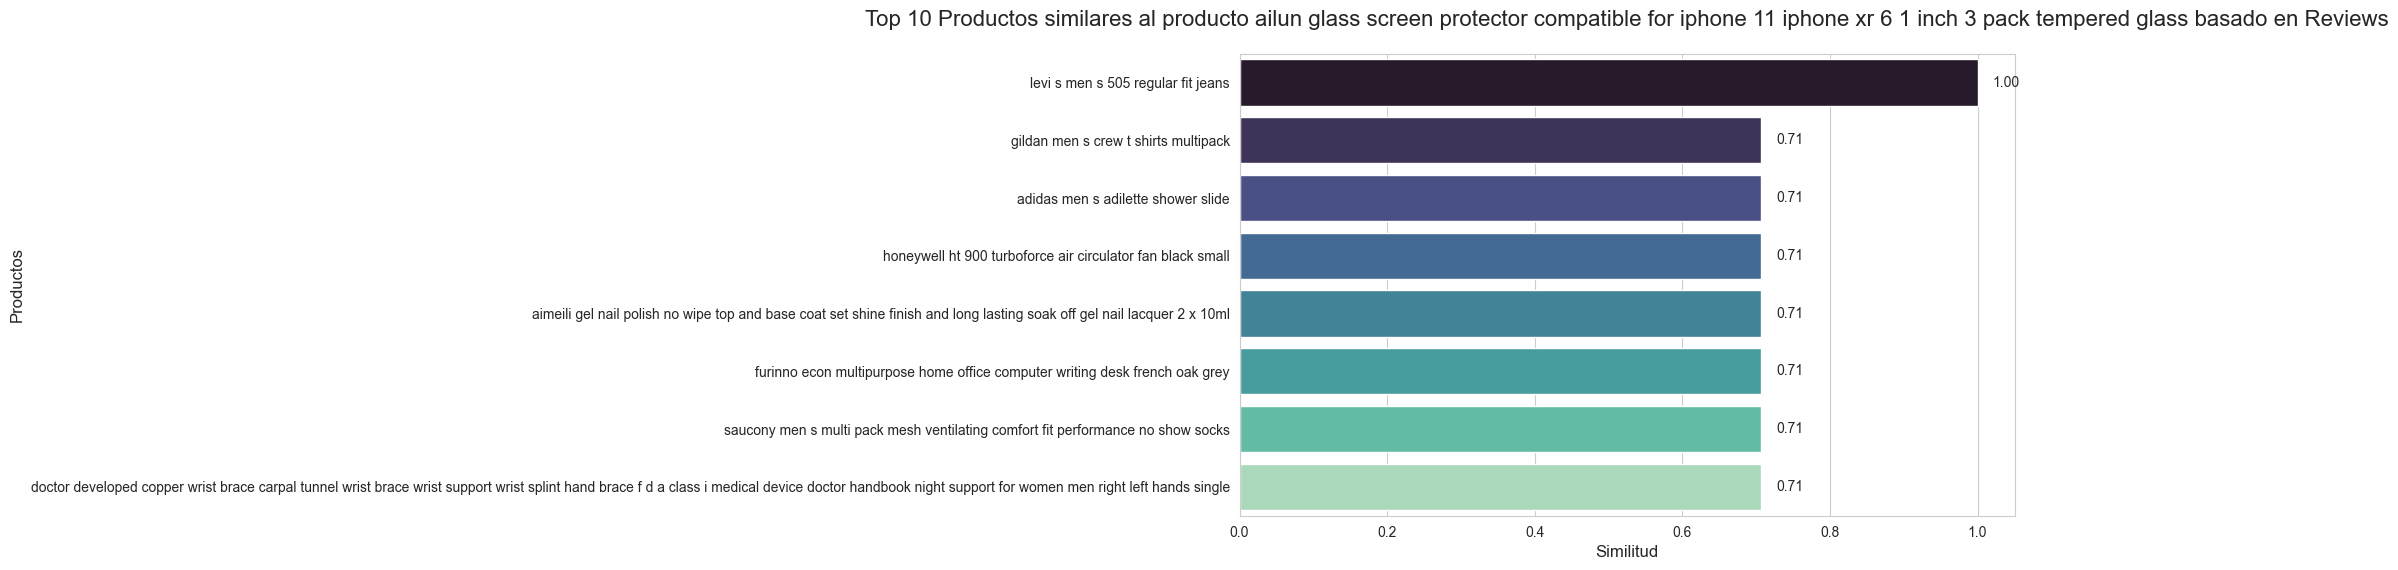

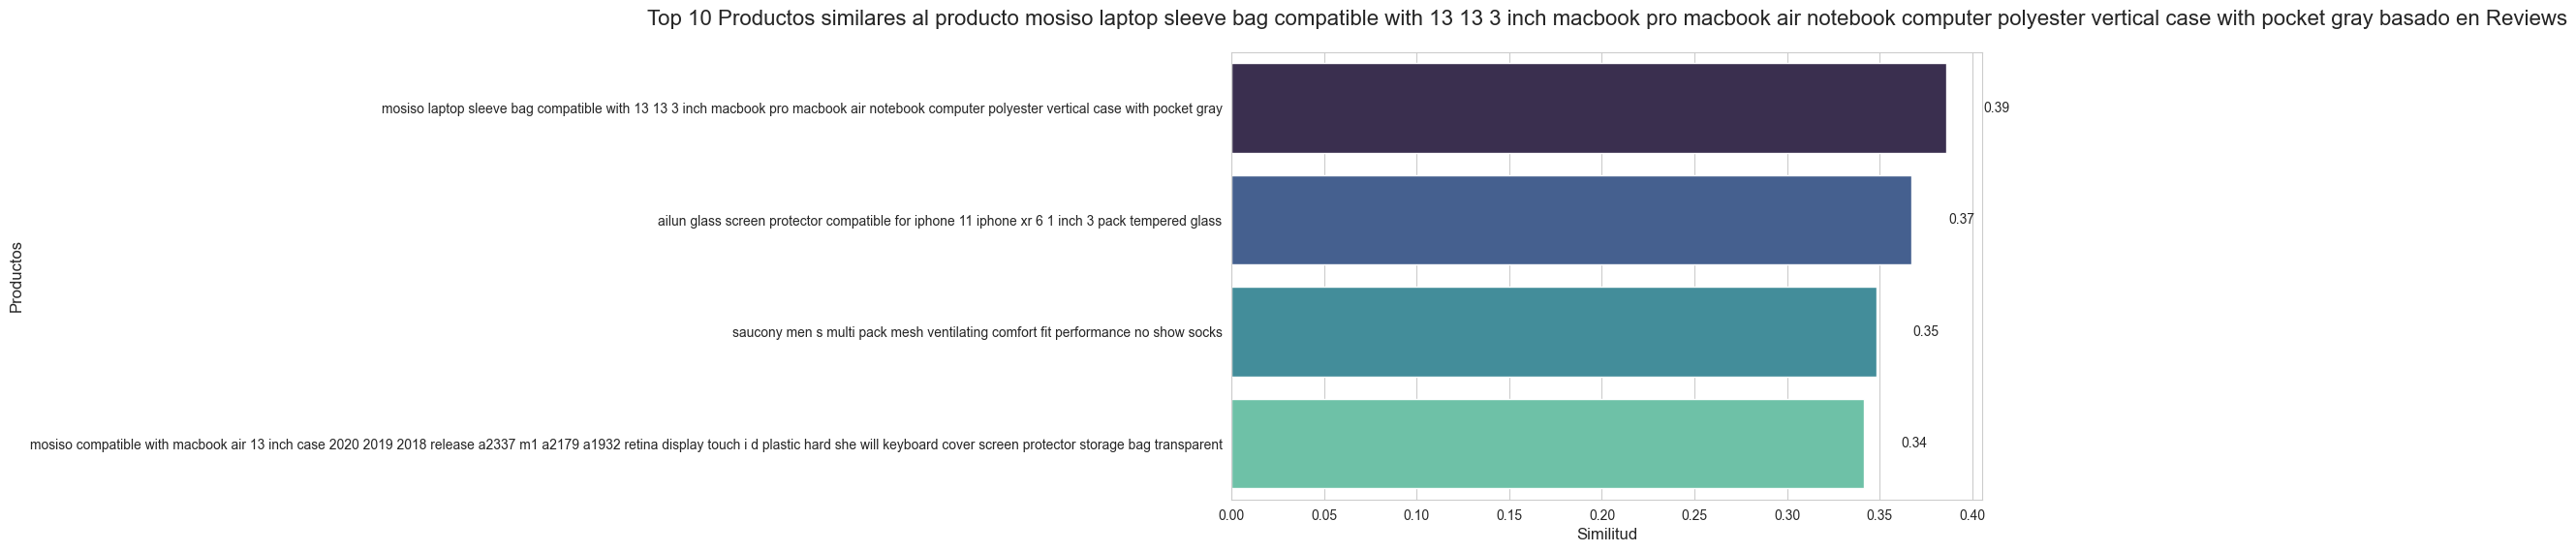

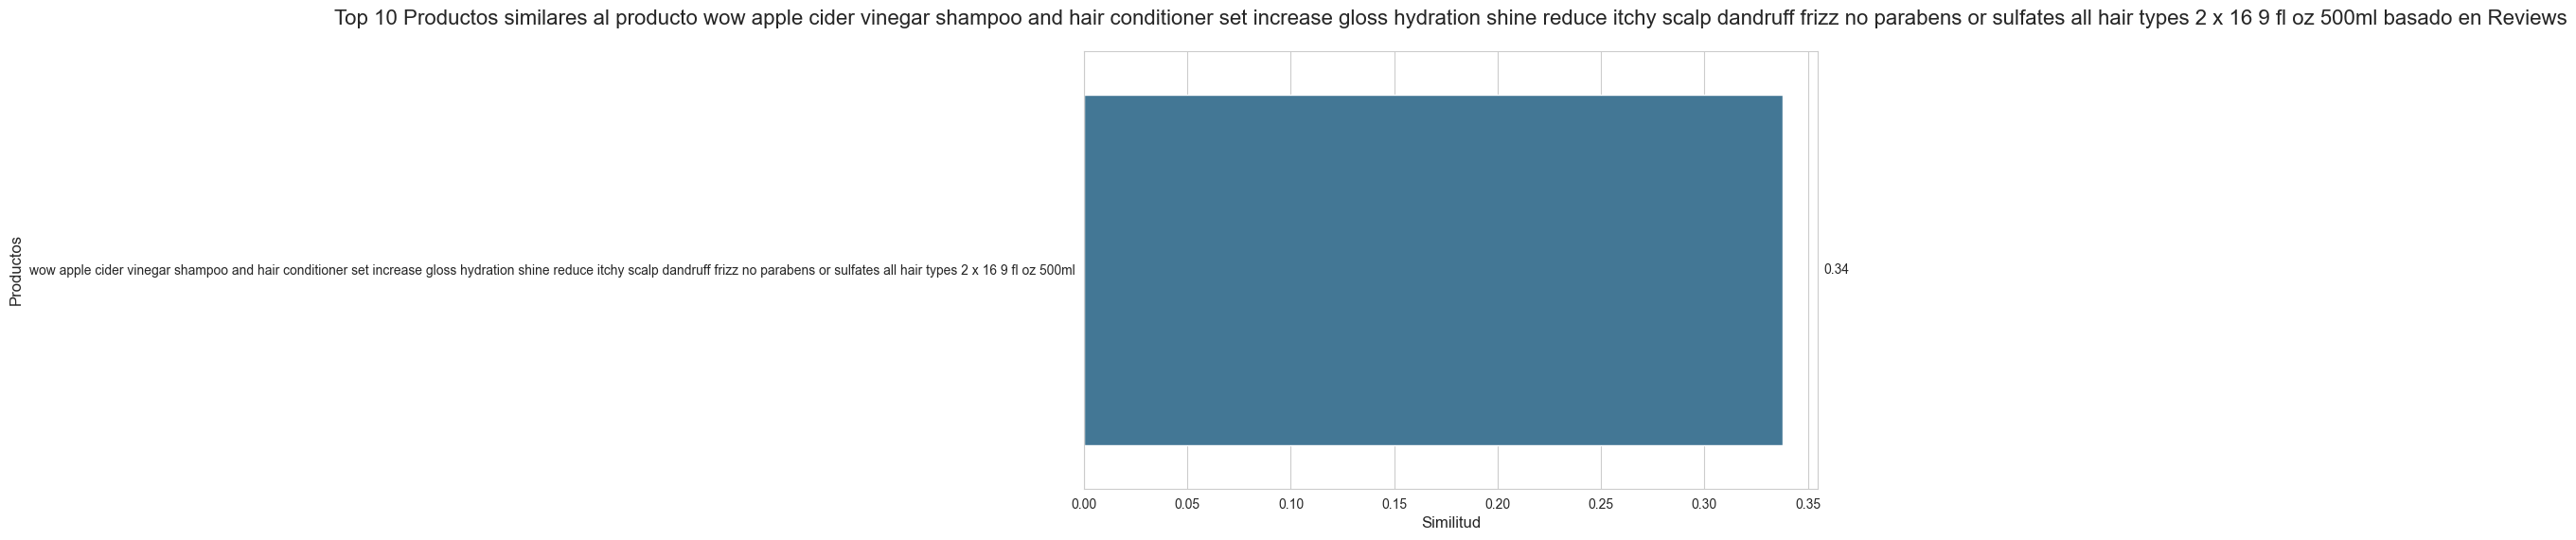

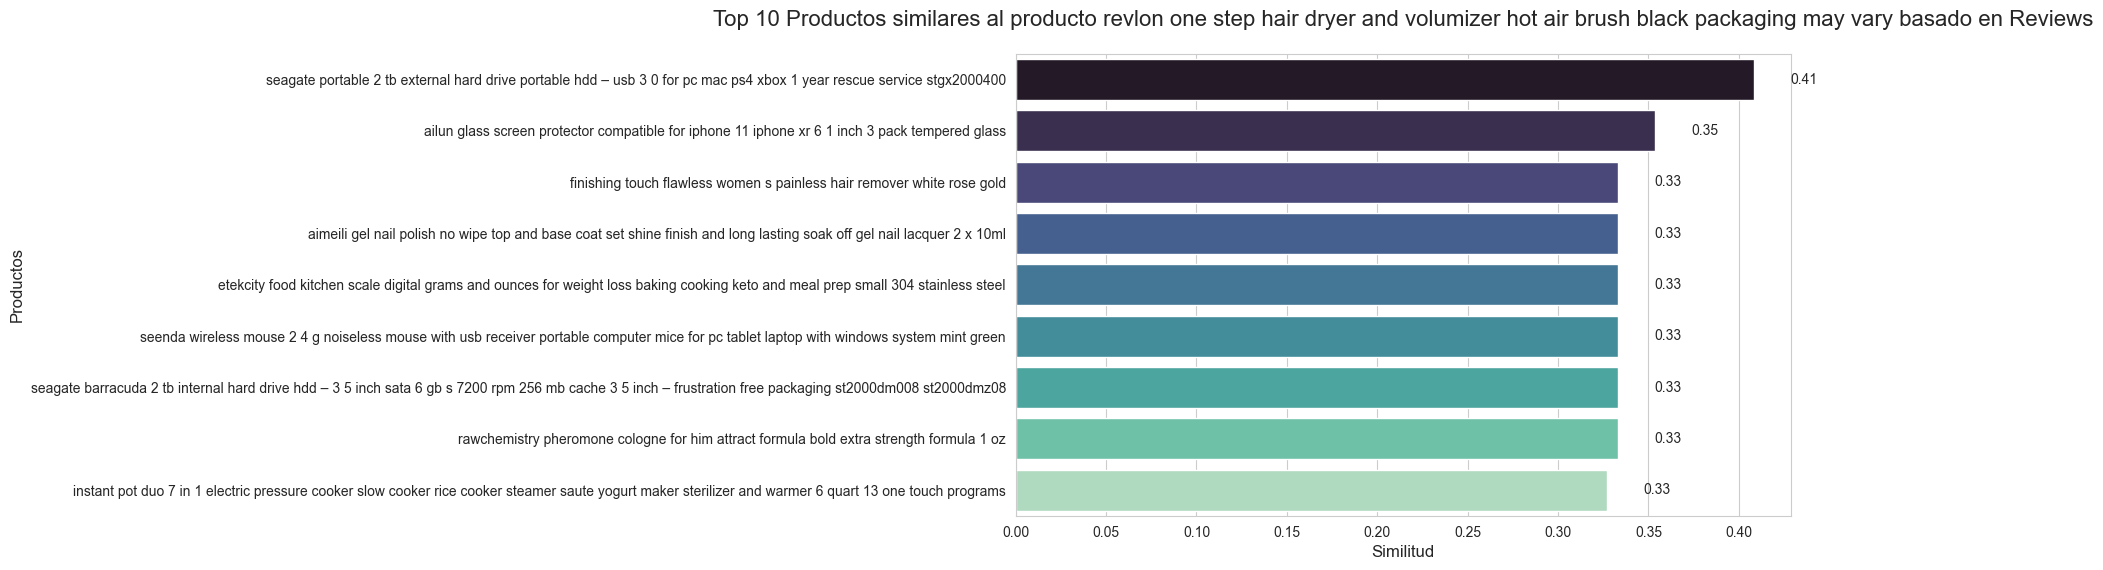

In [30]:
for producto in conjunto_prueba:  
    user_like_producto=producto

    product_index= f.get_index_from_name(user_like_producto,"producto_fuera_lista", datos)   #esto me devuelve el indice del producto

    #Aqui sacamos los indices y distancias del resto de los productos respecto a nuestro producto
    similar_products=list(enumerate(similarity[product_index]))

    #Lo ordenamos para que nos de los productos que más se parecen a nuestro producto
    sorted_products=sorted(similar_products, key=lambda x: x[1], reverse=True)
    #print(sorted_products)
    top_product ={}
    
    for i in sorted_products[1:11]:
        top_product[f.get_name_from_index(i[0], datos, "producto_fuera_lista")]=i[1]
    l_tup_ordenado=sorted(top_product.items(), key = lambda x : x[1], reverse=True)
    diccionario_ordenado = {clave: valor for clave, valor in l_tup_ordenado}
    #display(diccionario_ordenado)

    #grafico
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")

    sns.barplot(
        x=list(diccionario_ordenado.values()), 
        y=list(diccionario_ordenado.keys()), 
        palette="mako"
    )

    plt.title(f"Top 10 Productos similares al producto {producto} basado en Reviews", fontsize=16, pad=20)
    plt.xlabel("Similitud", fontsize=12)
    plt.ylabel("Productos", fontsize=12)

    # Añadir valores al final de cada barra
    for i, value in enumerate(diccionario_ordenado.values()):
        plt.text(value + 0.02, i, f"{value:.2f}", va='center', fontsize=10)

    plt.tight_layout()
    plt.show();

# **Caso 2**

**Limpiar las reviews**

In [31]:
def formatear_texto_adap(text):
    if not isinstance(text, str):  # no aseguramos que sea un texto
        raise ValueError("La entrada debe ser una cadena de texto.")
    text = contractions.fix(text)                      #Quita las contracciones
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    

    doc=nlp(text)

    
    stop_words = set(stopwords.words("english"))
    

    palabras_def=[]
    for palabra in doc:
        if palabra not in stop_words:
            palabras_def.append(palabra) 

    
    return palabras_def


In [32]:
datos["reviewText"]=datos["reviewText"].apply(formatear_texto_adap)

In [33]:
datos["review_fuera_lista"] = datos["reviewText"].apply(lambda x: ' '.join(str(token) for token in x))

In [34]:
datos["review_fuera_lista"].dtype

dtype('O')

In [35]:
datos["reviewText"][2]

[Very,
 easy,
 to,
 install,
 Worked,
 right,
 away,
 but,
 it,
 did,
 not,
 go,
 as,
 far,
 as,
 I,
 had,
 expected,
 It,
 was,
 a,
 good,
 value,
 hit,
 the,
 money]

In [36]:
datos["review_fuera_lista"][0]

'Nice lightweight brace but unfortunately was too large for my wrist It is adjustable but I guess I have a small wrist and it was way too big for me Did not offer enough support'

In [37]:
datos.head()

,reviewId,reviewDate,mainDepartment,subDepartment,productName,reviewTitle,reviewStar,reviewText,inconsistentStatus,producto_fuera_lista,review_fuera_lista
0,RXDM4W1ZL7L4L,"Reviewed in the United States on June 22, 2021",Sports and Outdoors,Outdoor Recreation,"[doctor, developed, copper, wrist, brace, carp...",One size does not fit all.,3.0,"[Nice, lightweight, brace, but, unfortunately,...",1,doctor developed copper wrist brace carpal tun...,Nice lightweight brace but unfortunately was t...
1,R2GINAKQJOSWEL,"Reviewed in the United States on August 27, 2021",Computers,Men's Clothing,"[fruit, of, the, loom, men, s, coolzone, boxer...",They were ok but thats it,4.0,"[Boxers, were, ok, The, color, did, start, to,...",0,fruit of the loom men s coolzone boxer briefs,Boxers were ok The color did start to fade pre...
2,RD5R7T2JNP104,"Reviewed in the United States on May 21, 2021",Computers,Networking Products,"[tp, link, ac750, wifi, extender, re220, cover...",Good if you need a little extra.,4.0,"[Very, easy, to, install, Worked, right, away,...",0,tp link ac750 wifi extender re220 covers up to...,Very easy to install Worked right away but it ...
3,R3UEHJJ17E730C,"Reviewed in the United States on March 7, 2021",Home and Kitchen,Bath,"[gorilla, grip, luxury, chenille, bathroom, ru...",Color wrong!!!,1.0,"[The, color, is, completely, different, than, ...",1,gorilla grip luxury chenille bathroom rug mat ...,The color is completely different than hunter ...
4,R2257OUFMQ8P5C,"Reviewed in the United States on October 17, 2020",Beauty and Personal Care,Hair Care,"[wow, apple, cider, vinegar, shampoo, and, hai...",I have 4A hair,2.0,"[From, reading, the, reviews, I, was, hoping, ...",0,wow apple cider vinegar shampoo and hair condi...,From reading the reviews I was hoping that the...


**Entrenar el modelo**

In [38]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\jaime\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [39]:
sentimientos=f.AnalisisSentimientos(datos,"review_fuera_lista")

In [40]:
sentimientos._preparar_datos()

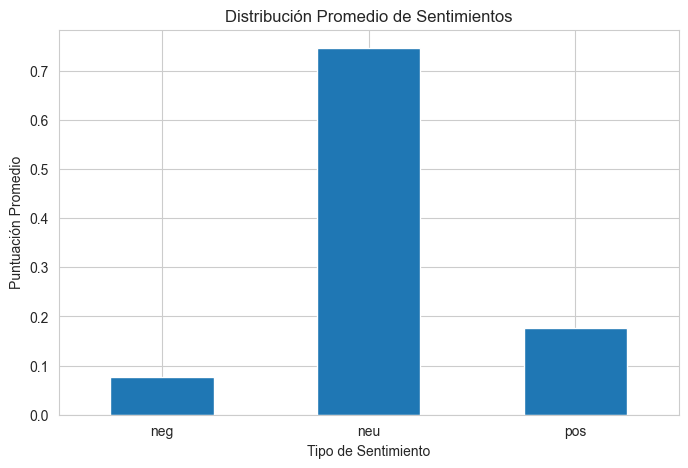

In [41]:
sentimientos.graficar_distribucion_sentimientos()

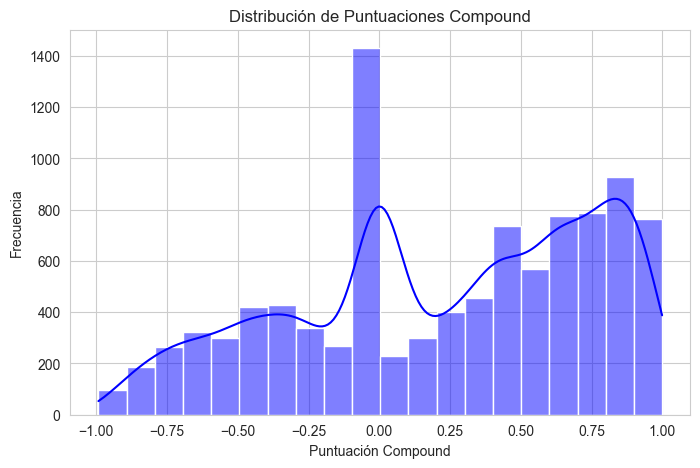

In [42]:
sentimientos.graficar_distribucion_compound()

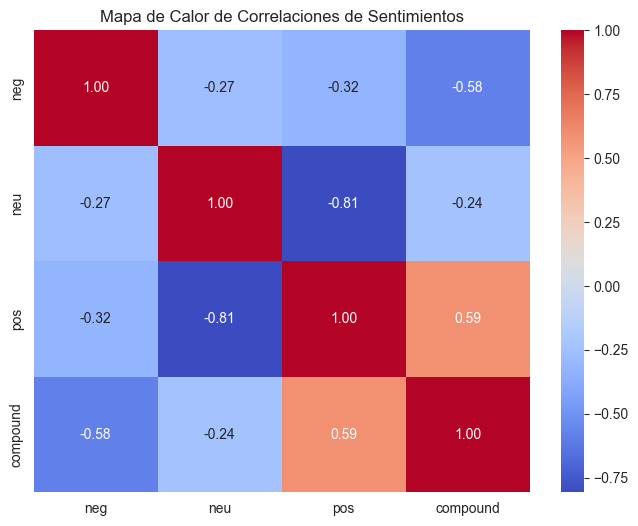

In [43]:
sentimientos.graficar_mapa_calor_sentimientos()

In [44]:
sentimientos.obtener_resumen()

,neg,neu,pos,compound
count,9995.000000,9995.000000,9995.000000,9995.000000
mean,0.076583,0.746413,0.175602,0.229604
std,0.115612,0.193569,0.194981,0.524816
min,0.000000,0.000000,0.000000,-0.992500
25%,0.000000,0.660000,0.000000,-0.135600
50%,0.034000,0.779000,0.124000,0.307100
75%,0.113000,0.872000,0.247500,0.694800
max,1.000000,1.000000,1.000000,0.999000


## CONCLUSIÓN:  
  

- El análisis de sentimientos observamos una tendencia general hacia la neutralidad en las reviews (ya que el compound representa el sentimiento general de un texto en una escala de -1 a 1), con una puntuación promedio bastante alta en la categoría neutral, mientras que las categorías positiva y negativa tienen puntuaciones menores mostrando muy poca polarización.
Además, la distribución de las puntuaciones compound muestra una concentración alrededor de valores cercanos a 0, con un pico cerca de 0.25, lo que indica que la mayoría de los textos tienen un tono neutral o si eso ligeramente positivo (debido a la leve inclinación hacia los sentimientos positivos que obseravmos en la curva).

- En el heatmap destaca una fuerte correlación negativa entre la categoría neutral y las categorías positivo (-0.81) y negativo (-0.27), lo que indica que los textos neutrales no presentan características de los otros dos tipos de sentimiento. Además, hay una correlación positiva moderada entre la categoría positivo y la puntuación compound (0.59), lo que nos reitera lo que ya hemos comentado y demuestra que puntuaciones altas en compound suelen asociarse con textos positivos. Por otro lado, las categorías negativo y compound tienen una correlación negativa moderada (-0.58), mostrando que puntuaciones bajas en compound están relacionadas con sentimientos/textos negativos.

- Finalmente, en los estadísticos principales se confirma lo mencionado y observado en las gráficas ya que las puntuaciones positivas tienen una media significativamente mayor que las negativas, aunque sigue predominando la neutralidad con la media más alta.Como último apunte, se observa como las puntuaciones de compound van de -0.99 a 1.00, mostrando que los textos abarcan desde tonos extremadamente negativos hasta los más positivos. 
